In [1]:
import sys
sys.path.append("../scripts")

import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataset_config import label_names_dict

save_dir = "../plots/notebook_plots/model_goodness_of_fit/"

In [2]:
def load_gp_data(path, name):
    
    with open(path) as f:
        gp_df = pd.read_json(f)
        gp_df['model'] = name
        
    return gp_df

def load_gpar_data(path, name, matrix_factorized=False):
    
    with open(path) as f:
        gpar_data = pd.read_json(f)
        
        dfs = []
        for i, row in gpar_data.iterrows():
            items = {
                'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                'index': row['index'],
                'output': row['outputs'],
                'size': row["size"],
#                 "train_time": row["train_time"],
#                 "predict_time": row["predict_time"],
                "rmse": row["rmse"],
                "mean_abs_err": row["mean_abs_err"],
                "mean_squ_err": row["mean_squ_err"],
            } 
            if "input_transformed" in row:
                items["transforms_used"] = f'{("input" if row["input_transformed"] else "")}_' \
                                           f'{("output" if row["output_transformed"] else "")}'
            
            df = pd.DataFrame(items)
            
            dfs.append(df)
        
    return pd.concat(dfs, axis=0, ignore_index=True)

In [3]:
old_data_path = {
    "fft": "../../old-boa-data/data/fft/pred",
    "stencil3d": "../../old-boa-data/data/stencil3d/pred"
}

new_data_path = {
    "fft": "../logs/fft/pred",
    "stencil3d": "../logs/stencil3d/pred",
    "gemm": "../logs/gemm/pred",
    "smaug": "../logs/smaug/pred",
}

old_ff_gp_file = "gp_runs.json"
old_ff_gp_aux_file = "gp_aux_runs.json"
old_gpar_file = "gpar_runs.json"
old_mf_gpar_file = "mf_gpar_runs.json"

ff_gp_file = "ff-gp_experiments.json"
ff_gp_aux_file = "ff-gp-aux_experiments.json"
gpar_file = "gpar_experiments.json"
mf_gpar_2_file = "mf-gpar-2_experiments.json"
mf_gpar_5_file = "mf-gpar-5_experiments.json"
mf_gpar_8_file = "mf-gpar-8_experiments.json"

In [4]:
!ls ../../old-boa-data/data/stencil3d/pred/

gpar_runs.json	gp_aux_runs.json  gp_runs.json	mf_gpar_runs.json


In [5]:
def read_model_statistics(model_dict):
    dfs = []

    for name, path in model_dict.items():
        with open(path) as f:
            gpar_data = pd.read_json(f)

            for i, row in gpar_data.iterrows():
                items = {
                    'model': name,
                    'index': row['index'],
                    'output': row['outputs'],
                    'size': row["size"],
        #                 "train_time": row["train_time"],
        #                 "predict_time": row["predict_time"],
                    "rmse": row["rmse"],
                    "mean_abs_err": row["mean_abs_err"],
                    "mean_squ_err": row["mean_squ_err"],
                } 
                if "input_transformed" in row:
                    items["transforms_used"] = f'{("input" if row["input_transformed"] else "")}_' \
                                               f'{("output" if row["output_transformed"] else "")}'

                if "std_mean_squ_err" in row:
                    items["std_mean_squ_err"] = row["std_mean_squ_err"]
                    items["std_mean_abs_err"] = row["std_mean_abs_err"]

                if "mean_predictive_variance" in row:
                    items["mean_predictive_variance"] = row["mean_predictive_variance"]
                    items["mean_predictive_std"] = row["mean_predictive_std"]

                df = pd.DataFrame(items)

                dfs.append(df)

    aggregated_df = pd.concat(dfs, axis=0, ignore_index=True)
    stats = aggregated_df.groupby(['model', 'output', 'size'])
    stats = stats.aggregate({"rmse": [np.mean, np.std],
                             "mean_abs_err": [np.mean, np.std],
                             "std_mean_abs_err": [np.mean, np.std],
                             "std_mean_squ_err": [np.mean, np.std],
                             "mean_predictive_variance": [np.mean, np.std],
                             "mean_predictive_std": [np.mean, np.std],
                            }).reset_index()
    
    return stats

In [6]:
def plot_model_stats(stats, task, save_name, outputs, sizes=None):

    line_style_dict = {
        "gp": "solid",
        "gpar": "dashed",
        "gp_aux": "dotted",
        "mf_gpar_2": "dashdot",
        "mf_gpar_5": "dashdot",
        "mf_gpar_8": "dashdot",
    }

    model_label = {
        "gp": "GP",
        "gpar": "GPAR",
        "gp_aux": "GP-aux",
        "mf_gpar_2": "MF-GPAR (2)",
        "mf_gpar_5": "MF-GPAR (5)",
        "mf_gpar_8": "MF-GPAR (8)"
    }

    stat_names = {
        "rmse": "RMSE",
        "mean_abs_err": "MAE", 
        "std_mean_abs_err": "SMAE", 
        "std_mean_squ_err": "SMSE",
        "mean_predictive_variance": "Mean Pred Var",
        "mean_predictive_std": "Mean Pred Std",
    }

    new_df = stats[stats["output"].isin(outputs)]

    fig, axes = plt.subplots(nrows=5, ncols=len(outputs), figsize=(5 * len(outputs), 22))

    for axes_row, statistic in zip(axes, ["rmse", 
                                          "mean_abs_err", 
                                          "std_mean_abs_err", 
                                          "std_mean_squ_err",
                                          "mean_predictive_variance",
                                          "mean_predictive_std"]):

        # Plot the outputs of interest
        for new_output, new_group in new_df.groupby('output'):

            ax = axes_row[outputs.index(new_output)]

            #-------------------------------------------
            # plot old stuff
            #-------------------------------------------


            for model, subgroup in new_group.groupby('model'):

                d = subgroup.sort_values("size")
                
                if sizes is not None:
                    d = d.loc[d["size"].isin(sizes)]

                # Interpolated plot of performance
                ax.plot(d["size"],
                        d[(statistic, 'mean')],
                        label=f"{model}",
                       zorder=-1)

                # Plot actual points
                ax.scatter(d['size'],
                          d[(statistic, 'mean')],
                          s=30,
                          c="white",
                          edgecolors='black',
                          zorder=1,
                          label=None)

                # Plot error bars
                ax.errorbar(d['size'],
                           d[(statistic, 'mean')],
                           yerr=d[(statistic, 'std')],
                           ecolor='black',
                           fmt='None',
                           capsize=3,
                           zorder=-1,
                           label=None)

                ax.set_xlim([15, 210])

                ax.set_ylabel(f'{stat_names[statistic]} {label_names_dict[new_output]}', fontsize=12)
                ax.set_xlabel('Dataset Size', fontsize=12)

                ax.legend()

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.4, top=.98)
    fig.savefig(save_dir + f"/{task}/{save_name}.png")
    plt.show()

In [7]:
!ls /scratch/gf332/BayesOpt/boa/logs/gemm/pred/ff-gp

20200403-090711  20200403-095157  20200413-101526  20200414-234315


In [8]:
fft_model_dict = {
    "gpar_old":  "../../old-boa-data/data/fft/pred/gpar_runs.json",
#    "mf-gpar_old":  "../../old-boa-data/data/fft/pred/mf_gpar_runs.json",
#     "gpar_before_rewrite": "/scratch/gf332/BayesOpt/boa/logs-old/fft/pred-21-02-2020/gpar_experiments.json",
    
    "gpar-correct": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200413-101325/gpar_experiments.json",
    "ff-gp-correct": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/ff-gp/20200413-101240/ff-gp_experiments.json",
    "mf-gpar-5 (adam-300)": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/mf-gpar-5/20200413-134203/mf-gpar-5_experiments.json",
 
    "gpar ci": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/gpar/20200414-114325/gpar_experiments.json",
    "ff-gp ci": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/ff-gp/20200414-150450/ff-gp_experiments.json",
    "mf-gpar-5 ci": "/scratch/gf332/BayesOpt/boa/logs/fft/pred/mf-gpar-5/20200414-115302/mf-gpar-5_experiments.json",
  
}

stencil3d_model_dict = {
#     "gpar_old":  "../../old-boa-data/data/stencil3d/pred/gpar_runs.json",
#     "mf-gpar-5_old":  "../../old-boa-data/data/stencil3d/pred/mf_gpar_runs.json",
    
    "ff-gp": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/ff-gp/20200401-234138/ff-gp_experiments.json",
    "gpar": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/gpar/20200402-113750/gpar_experiments.json",
#     "mf-gpar-5 (adam-300)": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/mf-gpar-5/20200401-234231/mf-gpar-5_experiments.json",
    
    "ff-gp-correct": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/ff-gp/20200413-101541/ff-gp_experiments.json",
    "gpar-correct": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/gpar/20200413-101509/gpar_experiments.json",
    "mf-gpar-5 correct": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/mf-gpar-5/20200413-134333/mf-gpar-5_experiments.json",
   
    "ff-gp-ci": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/ff-gp/20200414-201851/ff-gp_experiments.json",
    "gpar-ci": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/gpar/20200414-201920/gpar_experiments.json",
    "mf-gpar-5 ci": "/scratch/gf332/BayesOpt/boa/logs/stencil3d/pred/mf-gpar-5/20200414-115412/mf-gpar-5_experiments.json",

}

gemm_model_dict = {
    "ff-gp": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/ff-gp/20200403-095157/ff-gp_experiments.json",
    "gpar": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/gpar/20200403-095213/gpar_experiments.json",
    "mf-gpar-5 (adam-300)": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/mf-gpar-5/20200403-095143/mf-gpar-5_experiments.json",

    "ff-gp-correct": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/ff-gp/20200413-101526/ff-gp_experiments.json",
    "gpar-correct": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/gpar/20200413-101619/gpar_experiments.json",
    "mf-gpar-5 correct": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/mf-gpar-5/20200413-134454/mf-gpar-5_experiments.json",

    "ff-gp-ci": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/ff-gp/20200414-234315/ff-gp_experiments.json",
    "gpar-ci": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/gpar/20200414-202041/gpar_experiments.json",
    "mf-gpar-5 ci": "/scratch/gf332/BayesOpt/boa/logs/gemm/pred/mf-gpar-5/20200414-222238/mf-gpar-5_experiments.json",

}

smaug_model_dict = {
    "ff-gp": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/ff-gp/20200401-234309/ff-gp_experiments.json",
    "gpar": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/gpar/20200401-234425/gpar_experiments.json",
#    "gpar-adam-500": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/gpar/20200402-113853/gpar_experiments.json",
    "mf-gpar-5 (adam-300)": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/mf-gpar-5/20200401-234526/mf-gpar-5_experiments.json",

    "ff-gp-correct": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/ff-gp/20200413-101421/ff-gp_experiments.json",
    "gpar-correct": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/gpar/20200413-101604/gpar_experiments.json",
    "mf-gpar-5 correct": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/mf-gpar-5/20200413-134124/mf-gpar-5_experiments.json",
    
    "ff-gp-ci": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/ff-gp/20200414-222139/ff-gp_experiments.json",
    "gpar-ci": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/gpar/20200414-222320/gpar_experiments.json",
    "mf-gpar-5 ci": "/scratch/gf332/BayesOpt/boa/logs/smaug/pred/mf-gpar-5/20200414-115327/mf-gpar-5_experiments.json",
}

In [9]:
fft_stats = read_model_statistics(fft_model_dict)
stencil3d_stats = read_model_statistics(stencil3d_model_dict)
gemm_stats = read_model_statistics(gemm_model_dict)
smaug_stats = read_model_statistics(smaug_model_dict)

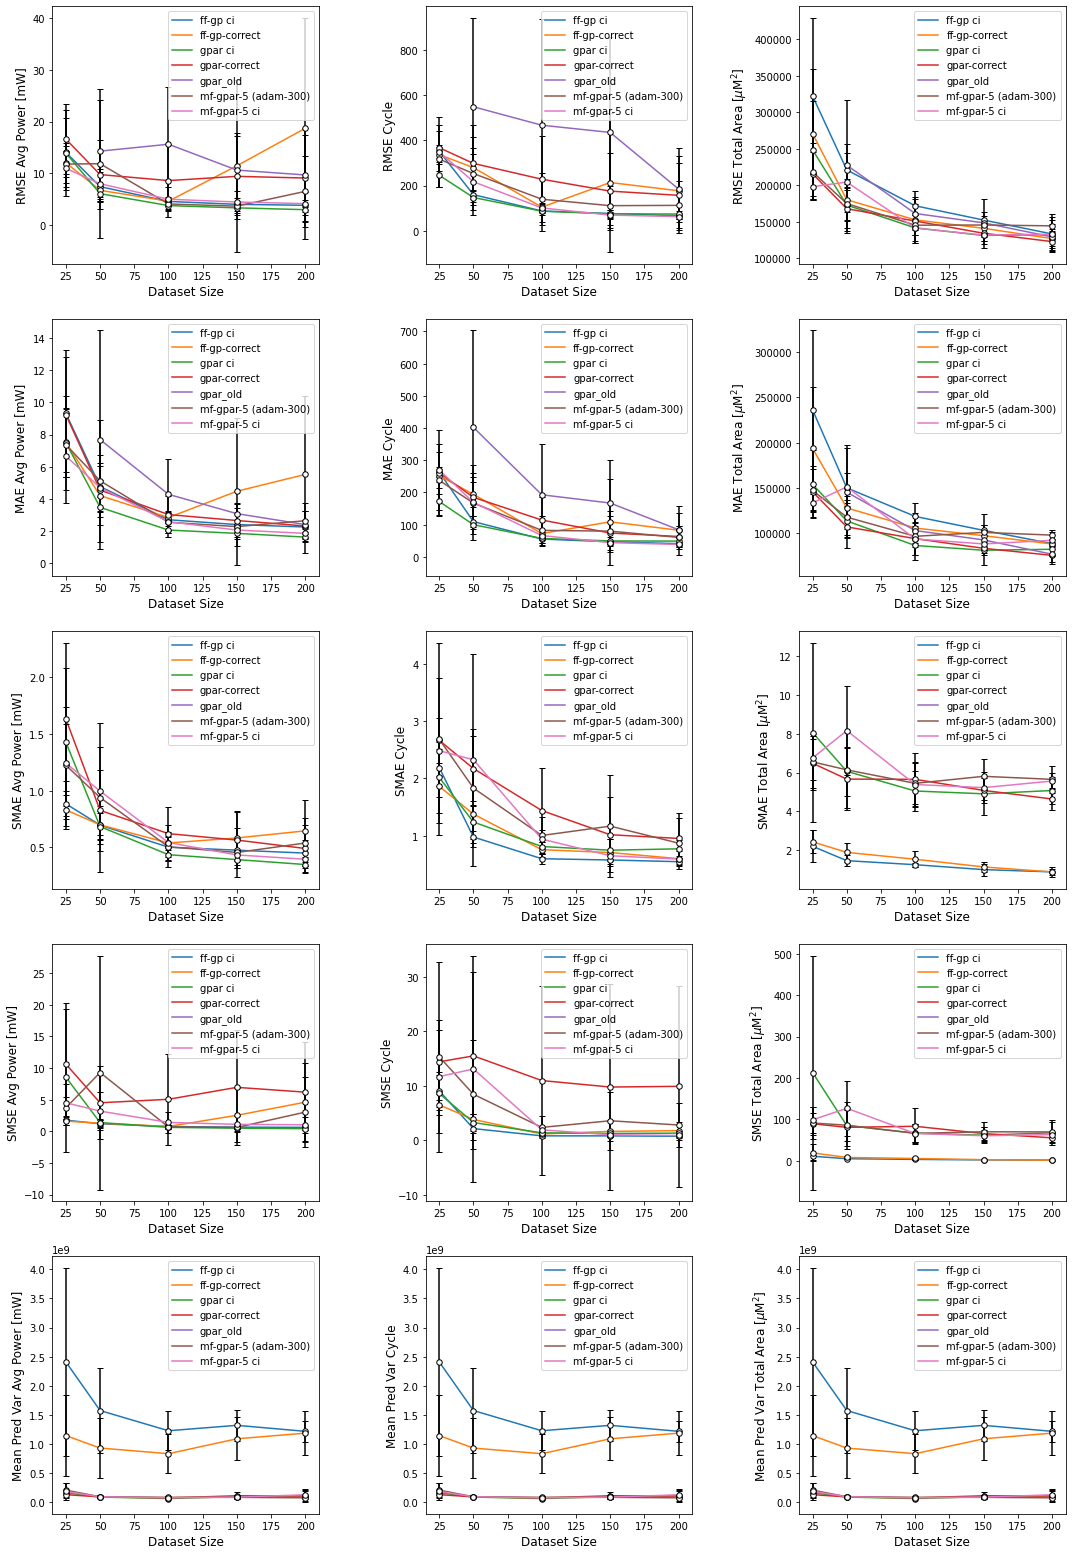

In [10]:
plot_model_stats(fft_stats,
                 task="fft",
                 save_name="model_comparison",
                 outputs=["avg_power", "cycle", "total_area"],
                 sizes=[25, 50, 100, 150, 200])

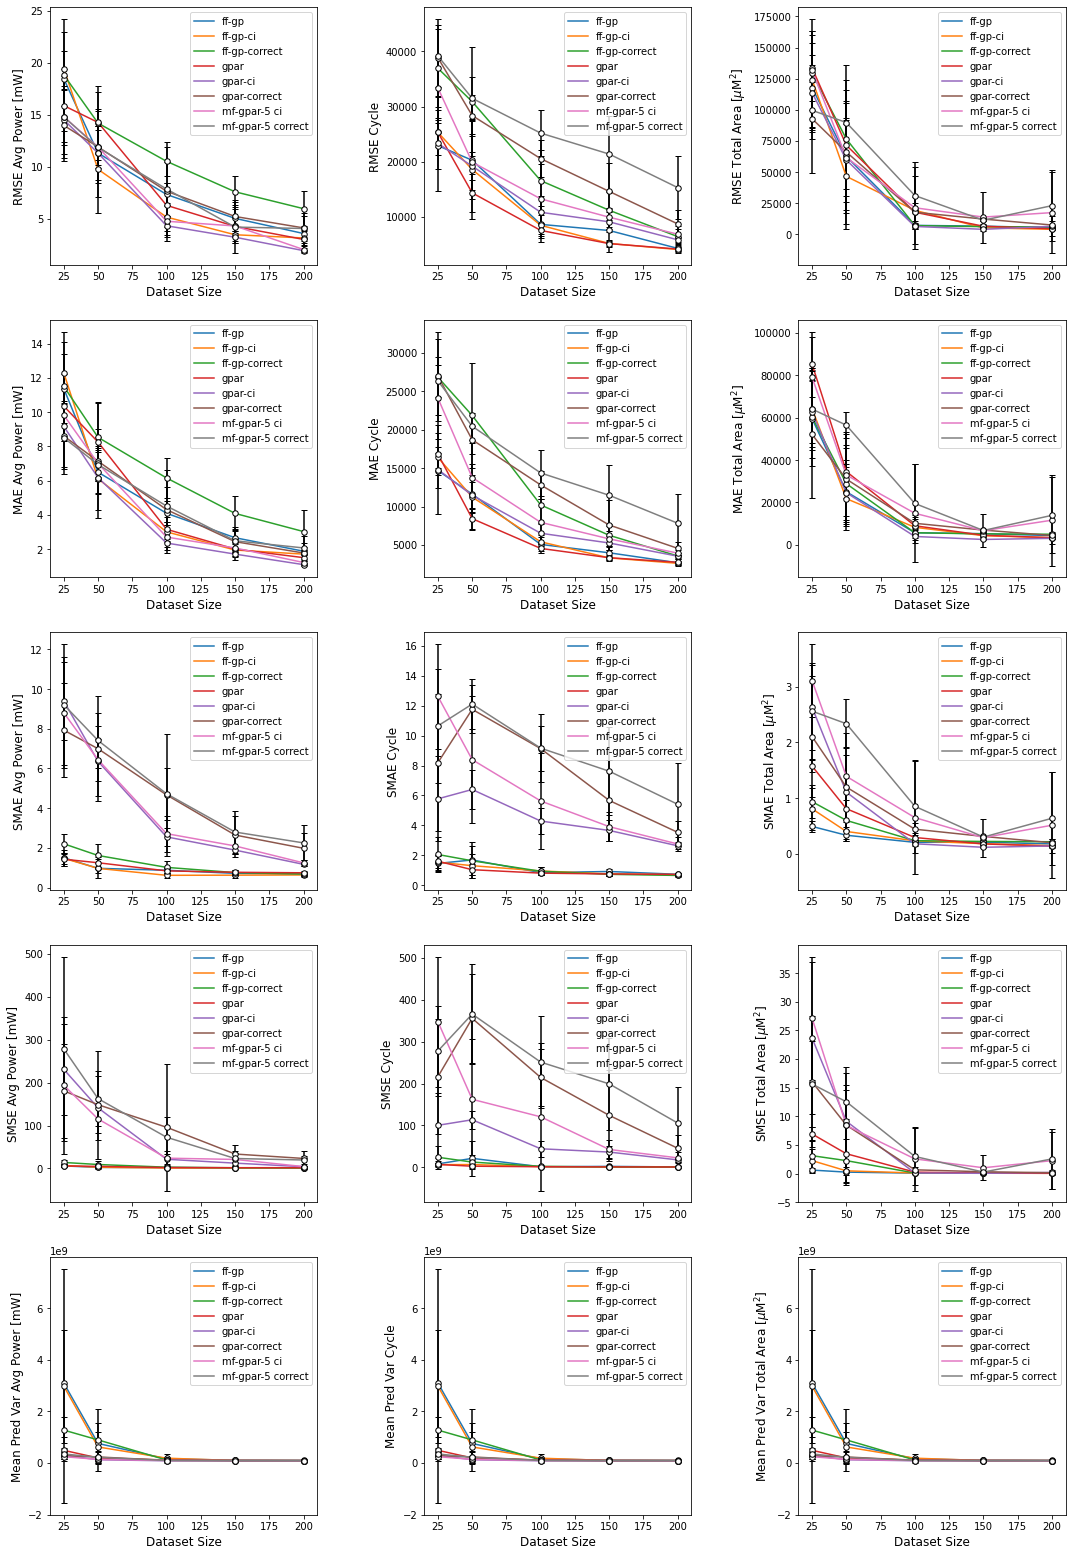

In [11]:
plot_model_stats(stencil3d_stats,
                 task="stencil3d",
                 save_name="model_comparison",
                 outputs=["avg_power", "cycle", "total_area"])

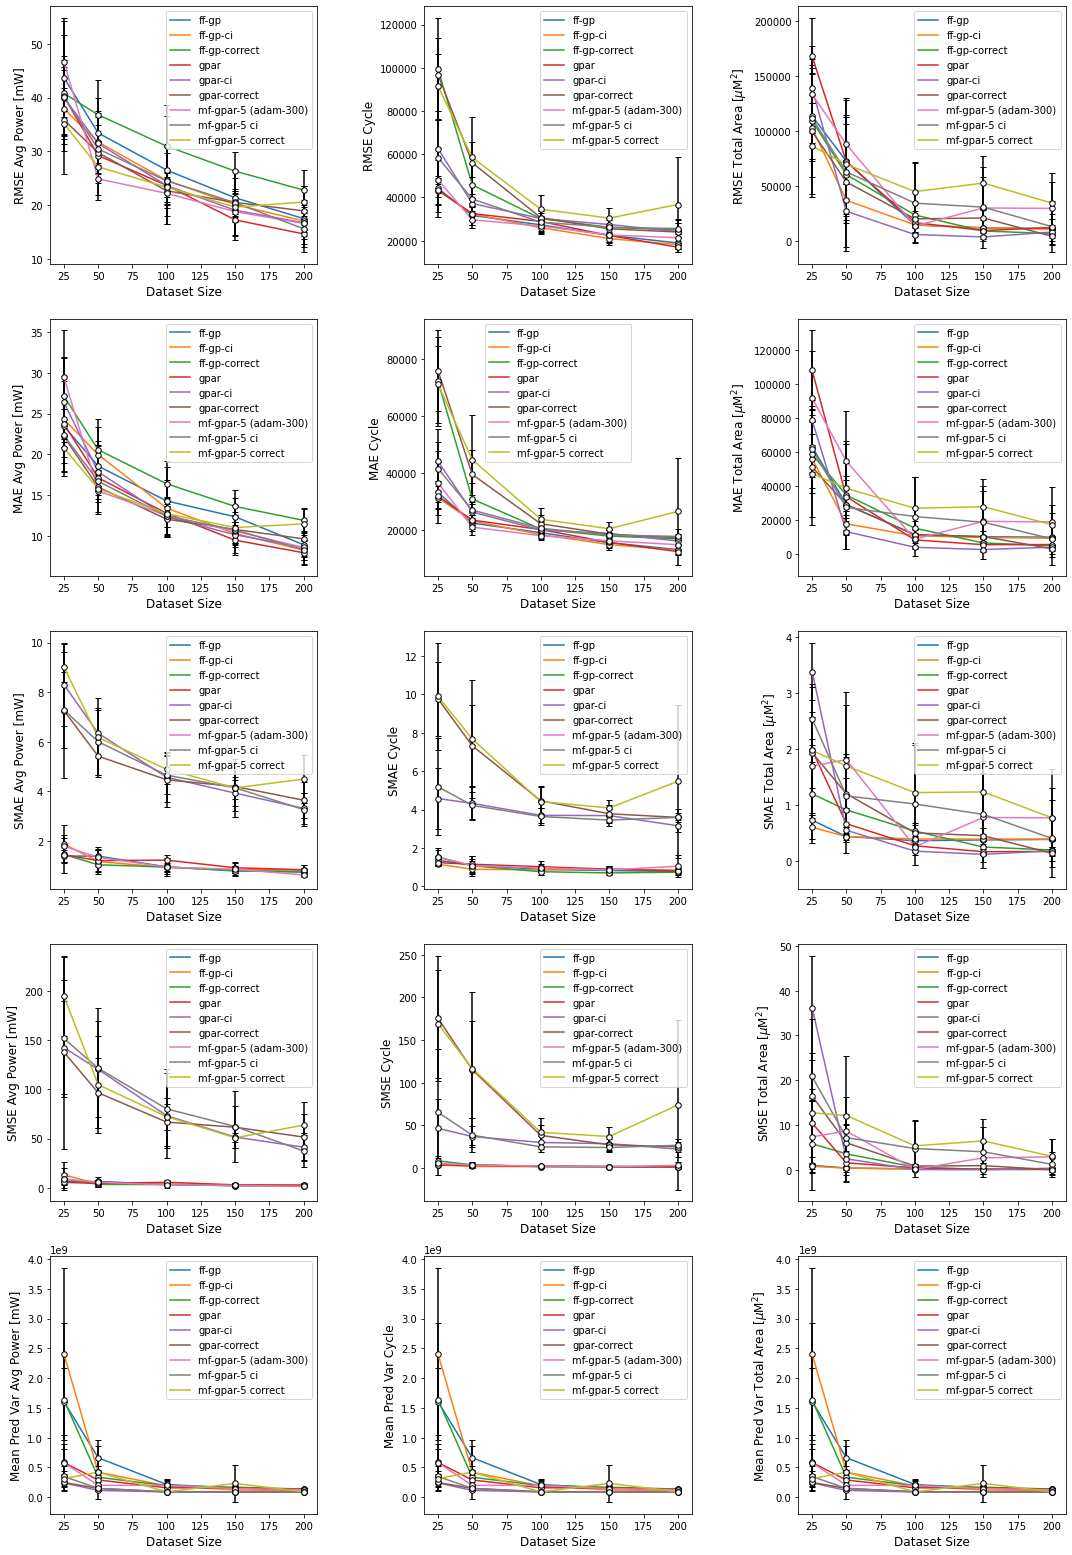

In [12]:
plot_model_stats(gemm_stats,
                 task="gemm",
                 save_name="model_comparison",
                 outputs=["avg_power", "cycle", "total_area"])

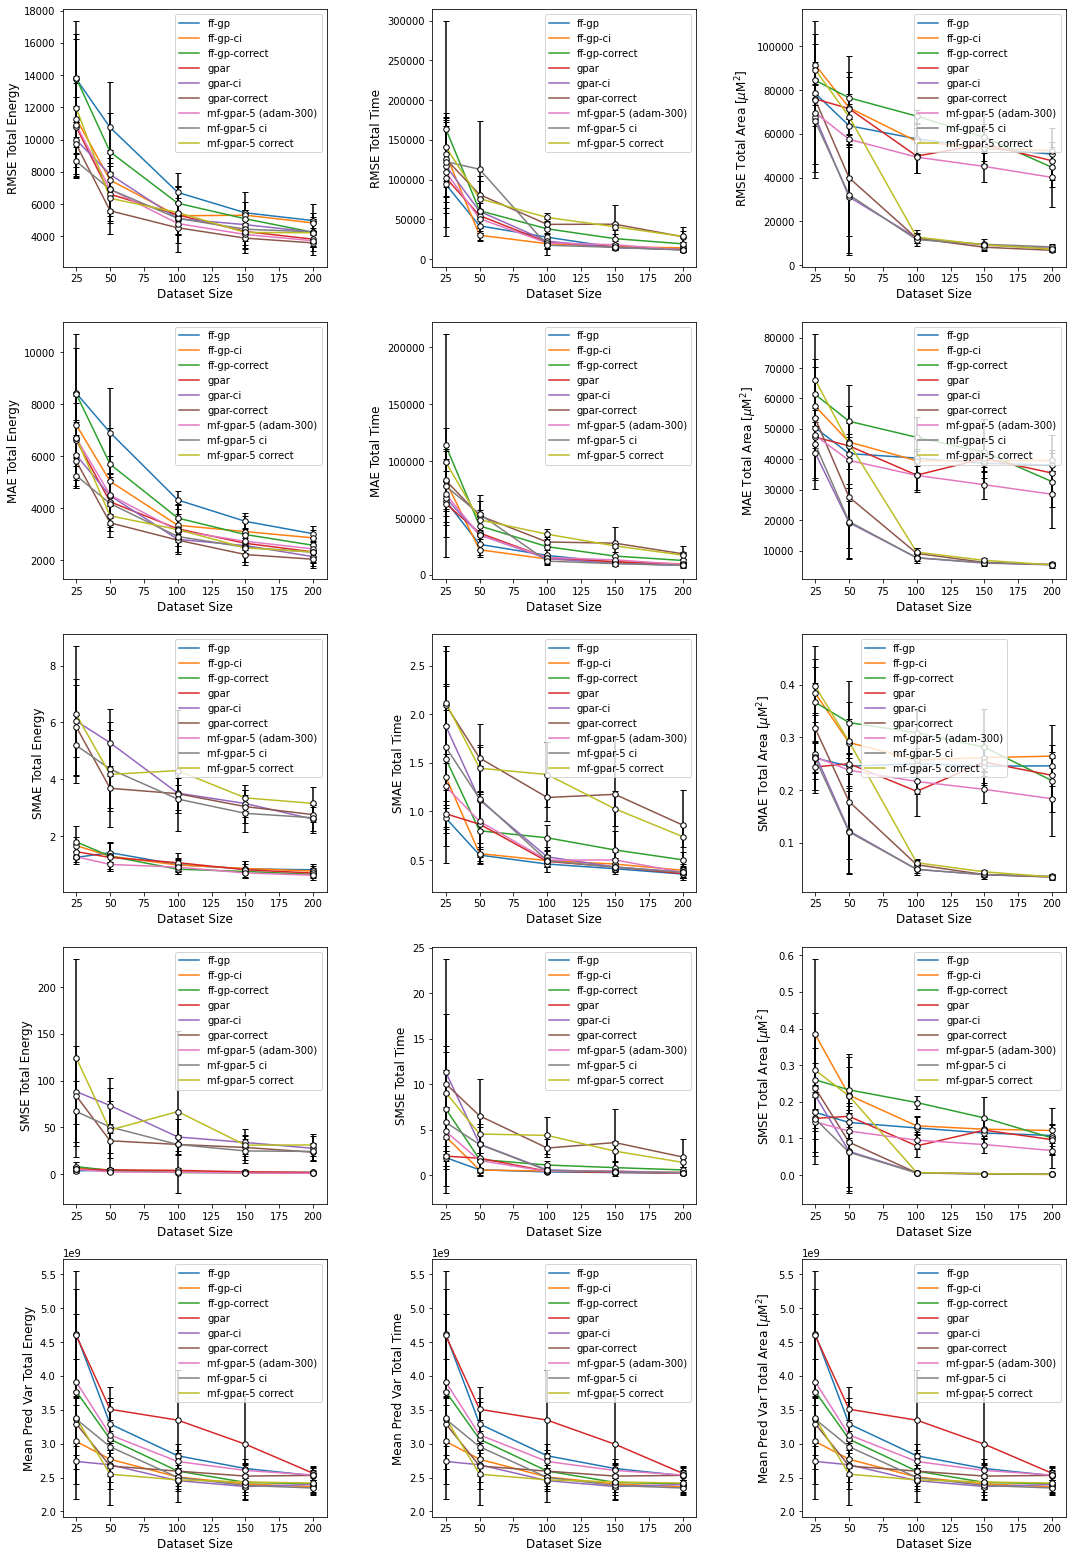

In [13]:
plot_model_stats(smaug_stats,
                 task="smaug",
                 save_name="model_comparison",
                 outputs=["total_energy", "total_time", "total_area"])